# Trabajo Práctico Auto ML

In [18]:
!pip install auto-sklearn

In [19]:
import numpy as np
import pandas as pd
import seaborn as sn
from matplotlib import pyplot as plt
import autosklearn.classification
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import explained_variance_score
from sklearn.tree import DecisionTreeClassifier

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [21]:
dataset = pd.read_csv("/content/drive/MyDrive/AutoML/loan_data.csv", comment="#")

# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [22]:
dataset.shape

(1854, 11)

In [23]:
#Normalización de datos
scaler = RobustScaler().fit(X_test)
X_test = scaler.transform(X_test)
X_train = scaler.transform(X_train)

## Descripción de los Datos




1. El conjunto de datos contiene informacion de referencia y de rendimiento de prestamos hipotecarios para 1854 casos. 

2. El TARGET es una variable binaria que indica si un solicitante finalmente incumplió con el pago o no. Los atributos son 11. 

3. Los atributos disponibles son los siguientes: 

- TARGET: 1 = cliente incumplió con el pago - 0 = préstamo reembolsado
- LOAN: Monto de la solicitud de préstamo
- MORTDUE: Monto adeudado de la hipoteca existente
- VALUE: Valor de la propiedad actual
- YOJ: Años en el trabajo actual
- DEROG: Número de informes despectivos importantes
- DELINQ: Número de líneas de crédito morosas
- CLAGE: Antigüedad de la línea comercial más antigua (en meses)
- NINQ: Número de líneas de crédito recientes
- CLNO: Número de líneas de crédito
- DEBTINC: Relación deuda-ingresos

4. Los atributos que creemos son más determinantes para la predicción son los siguientes: 

- LOAN
- YOJ
- DEROG 
- DELINQ
- NINQ
- DEBTINC

## Predicción con Modelos Lineales

### SGDClassifier con hiperparámetros por defecto

Se entrenar y evalua el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. 

Se evalua sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, y se reporta:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

In [24]:
#SGD : descenso del gradiente estocastico , #el valor 0 para random... implica que a partir de ese entero
# se determina la nueva semilla aleatoria. 
model = SGDClassifier(random_state=0) 

#Entrenamos el modelo con los datos del conjunto de training
model.fit(X_train, y_train) 

SGDClassifier(random_state=0)

In [25]:
#Hacemos predicciones sobre el conjunto de training y de test haciendo uso del modelo entrenado. 
y_predict_test = model.predict(X_test)
y_predict_train = model.predict(X_train)

In [26]:
names = ['Cliente Pagador', 'Cliente Deudor']

print('Reporte de clasificacion del conjunto de test: ')
print('')
print(classification_report(y_test, y_predict_test, target_names=names))
print('Reporte de clasificacion del conjunto de training: ')
print('')
print(classification_report(y_train, y_predict_train, target_names=names))

Reporte de clasificacion del conjunto de test: 

                 precision    recall  f1-score   support

Cliente Pagador       0.86      1.00      0.93       313
 Cliente Deudor       0.90      0.16      0.26        58

       accuracy                           0.87       371
      macro avg       0.88      0.58      0.60       371
   weighted avg       0.87      0.87      0.82       371

Reporte de clasificacion del conjunto de training: 

                 precision    recall  f1-score   support

Cliente Pagador       0.86      0.99      0.92      1232
 Cliente Deudor       0.76      0.23      0.35       251

       accuracy                           0.86      1483
      macro avg       0.81      0.61      0.64      1483
   weighted avg       0.85      0.86      0.82      1483



De las metricas observamos que de los 371 casos del conjunto de test, 313 son clientes pagadores y solo 58, deudores. Ahora bien, para la clase "Cliente Pagador" el modelo tiene una precision de 0.86. Esto signifca que el 86% de los clientes que supusimos pagadores realmente lo son. Además el modelo tiene una recall de 1, esto significa que identificamos el 100% de los pagadores. Luego, el valor de F1 es 0.93. 
En cuanto a la clase "Cliente Deudor", vemos que el modelo tiene una precision del 90%, esto significa que de los clientes que identificamos como deudores, el 90% lo era efectivamente. Ademas se identificaron el 16% de los deudores. Finalmente, F1 es 0.26. 
El modelo mide una accuracy del 87%. Sin embargo, esta metrica es engañosa si las clases están desbalanceadas, como en este caso donde tenemos solo 58 clientes deudores vs. 313 clientes pagadores. 


[[312   1]
 [ 49   9]]


Text(0.5, 1.0, 'Matriz de Confusion de Clasificador SGD por defecto')

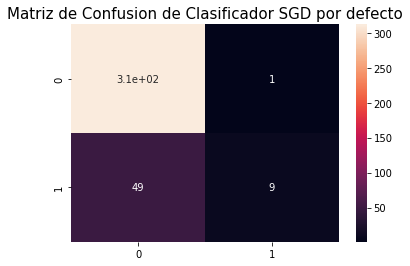

In [27]:
print(confusion_matrix(y_test, y_predict_test))
sn.heatmap(confusion_matrix(y_test, y_predict_test),annot=True)
plt.title('Matriz de Confusion de Clasificador SGD por defecto',fontsize=15)

De la matriz de confusion podemos ver que tenemos 312 TN (true negatives) y solo 9 TP (true positives). Es decir, identificamos 312 de los 313 pagadores pero solo 9 de los 58 deudores. Los FP son 1, un pagador que asumimos como deudor y los FN son 49, 49 clientes que asumimos como pagadores y resultaron deudores. Modelos mas optimos esperan mayores valores en la diagonal y valores pequeños a los lados. 

### SGDClassifier con ajuste de Hiperparámetros

Seleccionamos los valores para los hiperparámetros principales del SGDClassifier. 
Usamos grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.
Reportamos accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluamos sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Deseamos mejorar nuestro modelo. Para ello: comenzamos probando y listando las distintas combinaciones posibles ("a  mano") empleando 
ParameterGrid. 

In [28]:
param_grid = {
    'loss': ['hinge', 'log', 'squared_epsilon_insensitive','squared_loss','modified_huber','perceptron'],
    'learning_rate': ['optimal'],
    'alpha': [0.1, 0.01, 0.001, 0.0001]
}
prev_accuracy_score = 0
for params in ParameterGrid(param_grid):
    model = SGDClassifier(**params, random_state=0)
    model.fit(X_train, y_train)
    y_predict_test = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_predict_test, normalize=True)
    variance = explained_variance_score(y_test, y_predict_test, multioutput='uniform_average')
    print()
    print('Classification Report: ')
    print(classification_report(y_test, y_predict_test))
    print('Params: ',params)
    print('Accuracy: ', accuracy,' Variance: ', variance)
    print()
    if accuracy > prev_accuracy_score:
      best_model = model
      prev_accuracy_score = accuracy
      best_params = params
      best_variance = variance
print('')
print('')
print('El mejor modelo es: ', best_model, 'Con una accuracy de: ', prev_accuracy_score, 'Sus parámetros son: ', best_params, 'Y su varianza es: ', best_variance)


Classification Report: 
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       313
           1       1.00      0.17      0.29        58

    accuracy                           0.87       371
   macro avg       0.93      0.59      0.61       371
weighted avg       0.89      0.87      0.83       371

Params:  {'alpha': 0.1, 'learning_rate': 'optimal', 'loss': 'hinge'}
Accuracy:  0.8706199460916442  Variance:  0.14597333920898958


Classification Report: 
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       313
           1       1.00      0.19      0.32        58

    accuracy                           0.87       371
   macro avg       0.93      0.59      0.62       371
weighted avg       0.89      0.87      0.83       371

Params:  {'alpha': 0.1, 'learning_rate': 'optimal', 'loss': 'log'}
Accuracy:  0.8733153638814016  Variance:  0.16117660019830327


Classification Report: 
         

De acuerdo con esto el "mejor modelo" es el GDClassifier con parametros: {'alpha': 0.001, 'learning_rate': 'optimal', 'loss': 'hinge'} . Logra una accuracy de 0.889487870619946 y una varianza de:  0.25470970584995034. Veamos si mejora la matriz de confusion. 

In [29]:
best_model

SGDClassifier(alpha=0.001, random_state=0)

Reporte de clasificacion del conjunto de test: 

                 precision    recall  f1-score   support

Cliente Pagador       0.88      1.00      0.94       313
 Cliente Deudor       1.00      0.29      0.45        58

       accuracy                           0.89       371
      macro avg       0.94      0.65      0.70       371
   weighted avg       0.90      0.89      0.86       371

Reporte de clasificacion del conjunto de training: 

                 precision    recall  f1-score   support

Cliente Pagador       0.87      1.00      0.93      1232
 Cliente Deudor       0.92      0.27      0.42       251

       accuracy                           0.87      1483
      macro avg       0.90      0.64      0.68      1483
   weighted avg       0.88      0.87      0.84      1483

[[313   0]
 [ 41  17]]


Text(0.5, 1.0, 'Matriz de Confusion de Clasificador SGD con ParameterGrid')

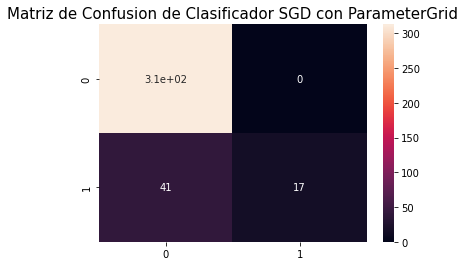

In [30]:
#si entrenamos con este best model que nos queda?

y_predict_train = best_model.predict(X_train)
y_predict_test = best_model.predict(X_test)


print('Reporte de clasificacion del conjunto de test: ')
print('')
print(classification_report(y_test, y_predict_test, target_names=names))
print('Reporte de clasificacion del conjunto de training: ')
print('')
print(classification_report(y_train, y_predict_train, target_names=names))

print(confusion_matrix(y_test, y_predict_test))
#print(confusion_matrix(y_train, y_predict_train))

sn.heatmap(confusion_matrix(y_test, y_predict_test),annot=True)
plt.title('Matriz de Confusion de Clasificador SGD con ParameterGrid',fontsize=15)

Bueno, acá observamos mejoras en la matriz de confusion, lo cual ya se intuia de los valores de las metricas. Por un lado, vemos que los True Positives son 313, es decir, el modelo predijo correctamente los 313 clientes pagadores. Tmb mejoró el valor de los TN, el modelo predijo 17 deudores (antes habiamos predicho solo 9). No hubo FP y si bien disminuyó el numero de FN, ahora son 41 y antes 49, sigue siendo elevado el numero de clientes morosos que no estamos prediciendo. 

Intentaremos mejorar aun mas el modelo. Para ello, podemos tambien emplear GridSearchCV para hacer validacion cruzada sobre una grilla de parametros (la grilla ya empleada anteriormente). Emplearemos como scoring la accuracy para evaluar la performance de cada modelo y cv=5. 


In [31]:
model = SGDClassifier(random_state=0)

best_model_cv = GridSearchCV(model, param_grid, scoring='accuracy', cv=5)
#xq usar accuracy como scoring si sabemos que no estan balanceadas las clases?
# y xq si usamos "recall_weighted", la cosa da fea igual?
best_model_cv.fit(X_train, y_train)

y_predict_train = best_model_cv.predict(X_train)
y_predict_test = best_model_cv.predict(X_test)

print('Reporte de clasificacion del conjunto de test: ')
print('')
print(classification_report(y_test, y_predict_test, target_names=names))
print('Reporte de clasificacion del conjunto de training: ')
print('')
print(classification_report(y_train, y_predict_train, target_names=names))


Reporte de clasificacion del conjunto de test: 

                 precision    recall  f1-score   support

Cliente Pagador       0.88      0.98      0.93       313
 Cliente Deudor       0.74      0.24      0.36        58

       accuracy                           0.87       371
      macro avg       0.81      0.61      0.64       371
   weighted avg       0.85      0.87      0.84       371

Reporte de clasificacion del conjunto de training: 

                 precision    recall  f1-score   support

Cliente Pagador       0.87      0.99      0.93      1232
 Cliente Deudor       0.85      0.29      0.44       251

       accuracy                           0.87      1483
      macro avg       0.86      0.64      0.68      1483
   weighted avg       0.87      0.87      0.84      1483



[[308   5]
 [ 44  14]]


Text(0.5, 1.0, 'Matriz de Confusion de Clasificador SGD con Cross-Validation')

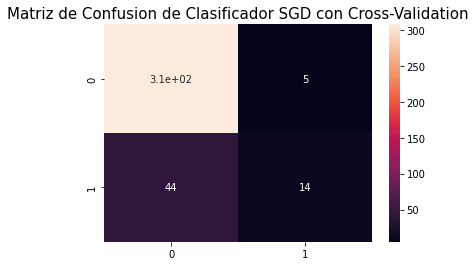

In [32]:
print(confusion_matrix(y_test, y_predict_test))
#print(confusion_matrix(y_train, y_predict_train))

sn.heatmap(confusion_matrix(y_test, y_predict_test),annot=True)
plt.title('Matriz de Confusion de Clasificador SGD con Cross-Validation',fontsize=15)

Bueno, vemos que la situacion empeoró aunque no sabemos si eso debia ocurrir. TN que antes se predecian bien pasaron a ser FP, el numero de FN (lo mas grave: predecir que un cliente va a pagar cuando no) aumentó y disminuyo el numero de TP.
Qué pasa entonces si en vez de usar la accuracy como scoring, usamos recall????


Reporte de clasificacion del conjunto de test: 

                 precision    recall  f1-score   support

Cliente Pagador       0.83      0.66      0.74       313
 Cliente Deudor       0.14      0.29      0.19        58

       accuracy                           0.60       371
      macro avg       0.49      0.48      0.46       371
   weighted avg       0.73      0.60      0.65       371

Reporte de clasificacion del conjunto de training: 

                 precision    recall  f1-score   support

Cliente Pagador       0.84      0.64      0.73      1232
 Cliente Deudor       0.18      0.38      0.24       251

       accuracy                           0.60      1483
      macro avg       0.51      0.51      0.49      1483
   weighted avg       0.72      0.60      0.64      1483

[[206 107]
 [ 41  17]]


Text(0.5, 1.0, 'Matriz de Confusion de Clasificador SGD con CV and recall')

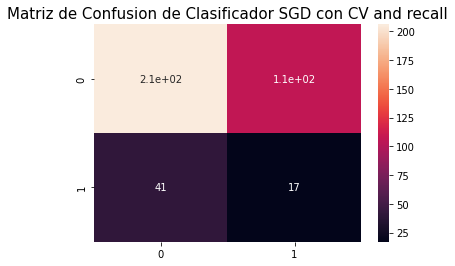

In [33]:
model = SGDClassifier(random_state=0)

best_model_cv = GridSearchCV(model, param_grid, scoring='recall', cv=5)
#xq usar accuracy como scoring si sabemos que no estan balanceadas las clases?
# y xq si usamos "recall_weighted", la cosa da fea igual?
best_model_cv.fit(X_train, y_train)

y_predict_train = best_model_cv.predict(X_train)
y_predict_test = best_model_cv.predict(X_test)

print('Reporte de clasificacion del conjunto de test: ')
print('')
print(classification_report(y_test, y_predict_test, target_names=names))
print('Reporte de clasificacion del conjunto de training: ')
print('')
print(classification_report(y_train, y_predict_train, target_names=names))

print(confusion_matrix(y_test, y_predict_test))
#print(confusion_matrix(y_train, y_predict_train))

sn.heatmap(confusion_matrix(y_test, y_predict_test),annot=True)
plt.title('Matriz de Confusion de Clasificador SGD con CV and recall',fontsize=15)


Mejora la recall relacionada con la clase cliente deudor pero empeora considerablemente la situacion con la clase cliente pagador. 

### Auto ML

In [34]:
from autosklearn.experimental.askl2 import AutoSklearn2Classifier
automl = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=100, 
                              per_run_time_limit=10, 
                              ensemble_size=1, 
                              initial_configurations_via_metalearning=0)
automl.fit(X_train, y_train)
predictions = automl.predict(X_test)

In [35]:
print(automl.sprint_statistics())

auto-sklearn results:
  Dataset name: 943a1f66-5610-11ec-8731-0242ac1c0002
  Metric: accuracy
  Best validation score: 0.902041
  Number of target algorithm runs: 18
  Number of successful target algorithm runs: 17
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 1
  Number of target algorithms that exceeded the memory limit: 0



In [36]:
# evaluate best model
y_hat = automl.predict(X_test)
acc = accuracy_score(y_test, y_hat)
print("Accuracy: %.3f" % acc)

Accuracy: 0.911


In [37]:
y_predict_test = automl.predict(X_test)
y_predict_train = automl.predict(X_train)

In [38]:
names = ['Cliente Pagador', 'Cliente Deudor']

print('Reporte de clasificacion del conjunto de test: ')
print('')
print(classification_report(y_test, y_predict_test, target_names=names))
print('Reporte de clasificacion del conjunto de training: ')
print('')
print(classification_report(y_train, y_predict_train, target_names=names))

Reporte de clasificacion del conjunto de test: 

                 precision    recall  f1-score   support

Cliente Pagador       0.91      0.99      0.95       313
 Cliente Deudor       0.90      0.48      0.63        58

       accuracy                           0.91       371
      macro avg       0.91      0.74      0.79       371
   weighted avg       0.91      0.91      0.90       371

Reporte de clasificacion del conjunto de training: 

                 precision    recall  f1-score   support

Cliente Pagador       0.96      1.00      0.98      1232
 Cliente Deudor       1.00      0.81      0.89       251

       accuracy                           0.97      1483
      macro avg       0.98      0.91      0.94      1483
   weighted avg       0.97      0.97      0.97      1483



[[310   3]
 [ 30  28]]


Text(0.5, 1.0, 'Matriz de Confusion de Auto ML')

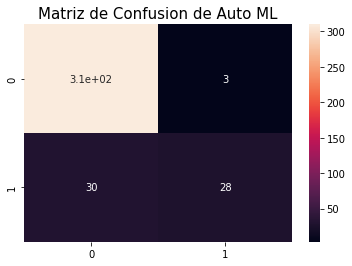

In [40]:
print(confusion_matrix(y_test, y_predict_test))
sn.heatmap(confusion_matrix(y_test, y_predict_test),annot=True)
plt.title('Matriz de Confusion de Auto ML',fontsize=15)

Podemos comparar AUTO ML con SGDClassifier con ajuste de hiperparámetros y observamos una mejora en la predicción de los datos. 

Para SGDClassifier 
*   Precision Pagador 0.87 y Deudor 0.92
*   Recall    Pagador 1.00 y Deudor 0.27
*   f1        Pagador 0.93 y Deudor 0.42


Para AutoMl
* Precision Pagador 0.96 y Deudor 1.00
* Recall    Pagador 1.00 y Deudor 0.81
* f1        Pagador 0.98 y Deudor 0.89